In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
import time
from helper_fns import yaml_load

def timed_exec(fn, *args):
    start = time.time()
    res = fn(*args)
    elapsed = time.time() - start
    return elapsed, *res


In [2]:
from helper_fns import spawn_models
from mpc import MPC

mpc_params = yaml_load('config/mpc_params.yaml')
ipopt_options = yaml_load('config/ipopt_options.yaml')

_, robots, contacts = spawn_models(robot_path = "config/franka.yaml",
                                   attr_path  = "config/attrs.yaml", 
                                   contact_path = "config/contact_test.yaml",
                                   sym_vars = [])

q0 = np.ones(7)
dq0 = 0.03*np.ones(7)

params = {'q': q0,
          'dq': dq0,
          'belief_free':1.0,
          'belief_point':0.0,
          'imp_stiff':400*ca.DM.ones(3),}

In [3]:
# MPC only, i.e. without iCEM warmstart
mpc_params = yaml_load('config/mpc_params.yaml')
ipopt_options['ipopt.print_level'] = 0
mpc = MPC(robots, mpc_params=mpc_params, ipopt_options=ipopt_options)

params['belief_free'] = 1.0
params['belief_point'] = 0.0

t_mpc_free_cold, cost, res = timed_exec(mpc.solve, params)
t_mpc_free_warm, cost_free, res = timed_exec(mpc.solve, params)

params['belief_free'] = 0.0
params['belief_point'] = 1.0

t_mpc_point, cost_point, res_point = timed_exec(mpc.solve, params)

print(f"Free space cold {t_mpc_free_cold}, Free space warm {t_mpc_free_warm}, Point: {t_mpc_point}")
print(f"Free space: {t_mpc_free_warm}, {cost_free} \n     Point: {t_mpc_point}, {cost_point}")
res['imp_stiff'] = params['imp_stiff']
traj_mpc = robots['point'].get_ext_state(res_point)
#print(traj_mpc['contact_1/F'][0,:])
#print(traj_mpc['F_imp'])
print(traj_mpc['imp_rest'])

Adding contact setpoint cost for contact_1/F

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Free space cold 0.758155345916748, Free space warm 0.011579751968383789, Point: 0.024312973022460938
Free space: 0.011579751968383789, 2.39384 
     Point: 0.024312973022460938, 2.43984
[[-0.7244394  -0.60768681 -0.53983855 -0.48294689 -0.43100594 -0.38391175
  -0.34241799 -0.30689182 -0.27711132 -0.25241256 -0.2319057  -0.21464359
  -0.19971646 -0.18628422 -0.17356334 -0.16076987 -0.14697895 -0.13073888
  -0.10883536 -0.07176212]
 [ 0.2517675   0.1777768   0.14595809  0.12453442  0.11008009  0.10243176
   0.10087923  0.10414955  0.11085323  0.11978298  0.13002

In [4]:
# iCEM-only result
mpc_params = yaml_load('config/mpc_params.yaml')
_, robots, contacts = spawn_models(robot_path = "config/franka.yaml",
                                   attr_path  = "config/attrs.yaml", 
                                   contact_path = "config/contact_test.yaml",
                                   sym_vars = [])

mpc = MPC(robots, mpc_params=mpc_params, ipopt_options=ipopt_options)
mpc_params['num_iter'] = 30
mpc.icem_init()

params['belief_free'] = 1.0
params['belief_point'] = 0.0
time_cem_free, cost_free, res = timed_exec(mpc.icem_solve, params)

params['belief_free'] = 0.0
params['belief_point'] = 1.0
time_cem_point, cost_point, res = timed_exec(mpc.icem_solve, params)
print(f"Free space: {time_cem_free}, {cost_free} \n     Point: {time_cem_point}, {cost_point}")
traj_cem = robots['point'].get_ext_state(res)
#print(traj_cem['imp_rest'])

Adding contact setpoint cost for contact_1/F
Free space: 0.042706966400146484, 3.19806 
     Point: 0.040445804595947266, 3.05311


In [8]:
iters = [0, 1, 2, 3, 4, 5, 10, 15]
N = 15
mpc = MPC(robots, mpc_params=mpc_params, ipopt_options=ipopt_options, icem=False)
iter_times_mean = []
iter_times_std = []
iter_cost_mean = []
iter_cost_std = []
mpc.solve(params)
for n_iter in iters:
    times = []
    costs = []
    for _ in range(N):
        mpc.reset_warmstart()
        params['belief_free'] = 1.0
        params['belief_point'] = 0.0 
        mpc.solve(params)
        
        params['belief_free'] = 0.0
        params['belief_point'] = 1.0
        params['q'] = 0.005*np.random.randn(7) # perturb initial state
        params['dq'] = 0.01*np.random.randn(7) # perturb initial state
        tic = time.perf_counter()
        if n_iter > 0: mpc.icem_warmstart(params, num_iter=n_iter)
        cost, _ = mpc.solve(params)
        times.append(time.perf_counter()-tic)
        costs.append(np.squeeze(cost.full()))
    iter_times_mean.append(np.mean(times))
    iter_times_std.append(np.std(times))
    iter_cost_mean.append(np.mean(costs))
    iter_cost_std.append(np.std(costs))

Adding contact setpoint cost for contact_1/F


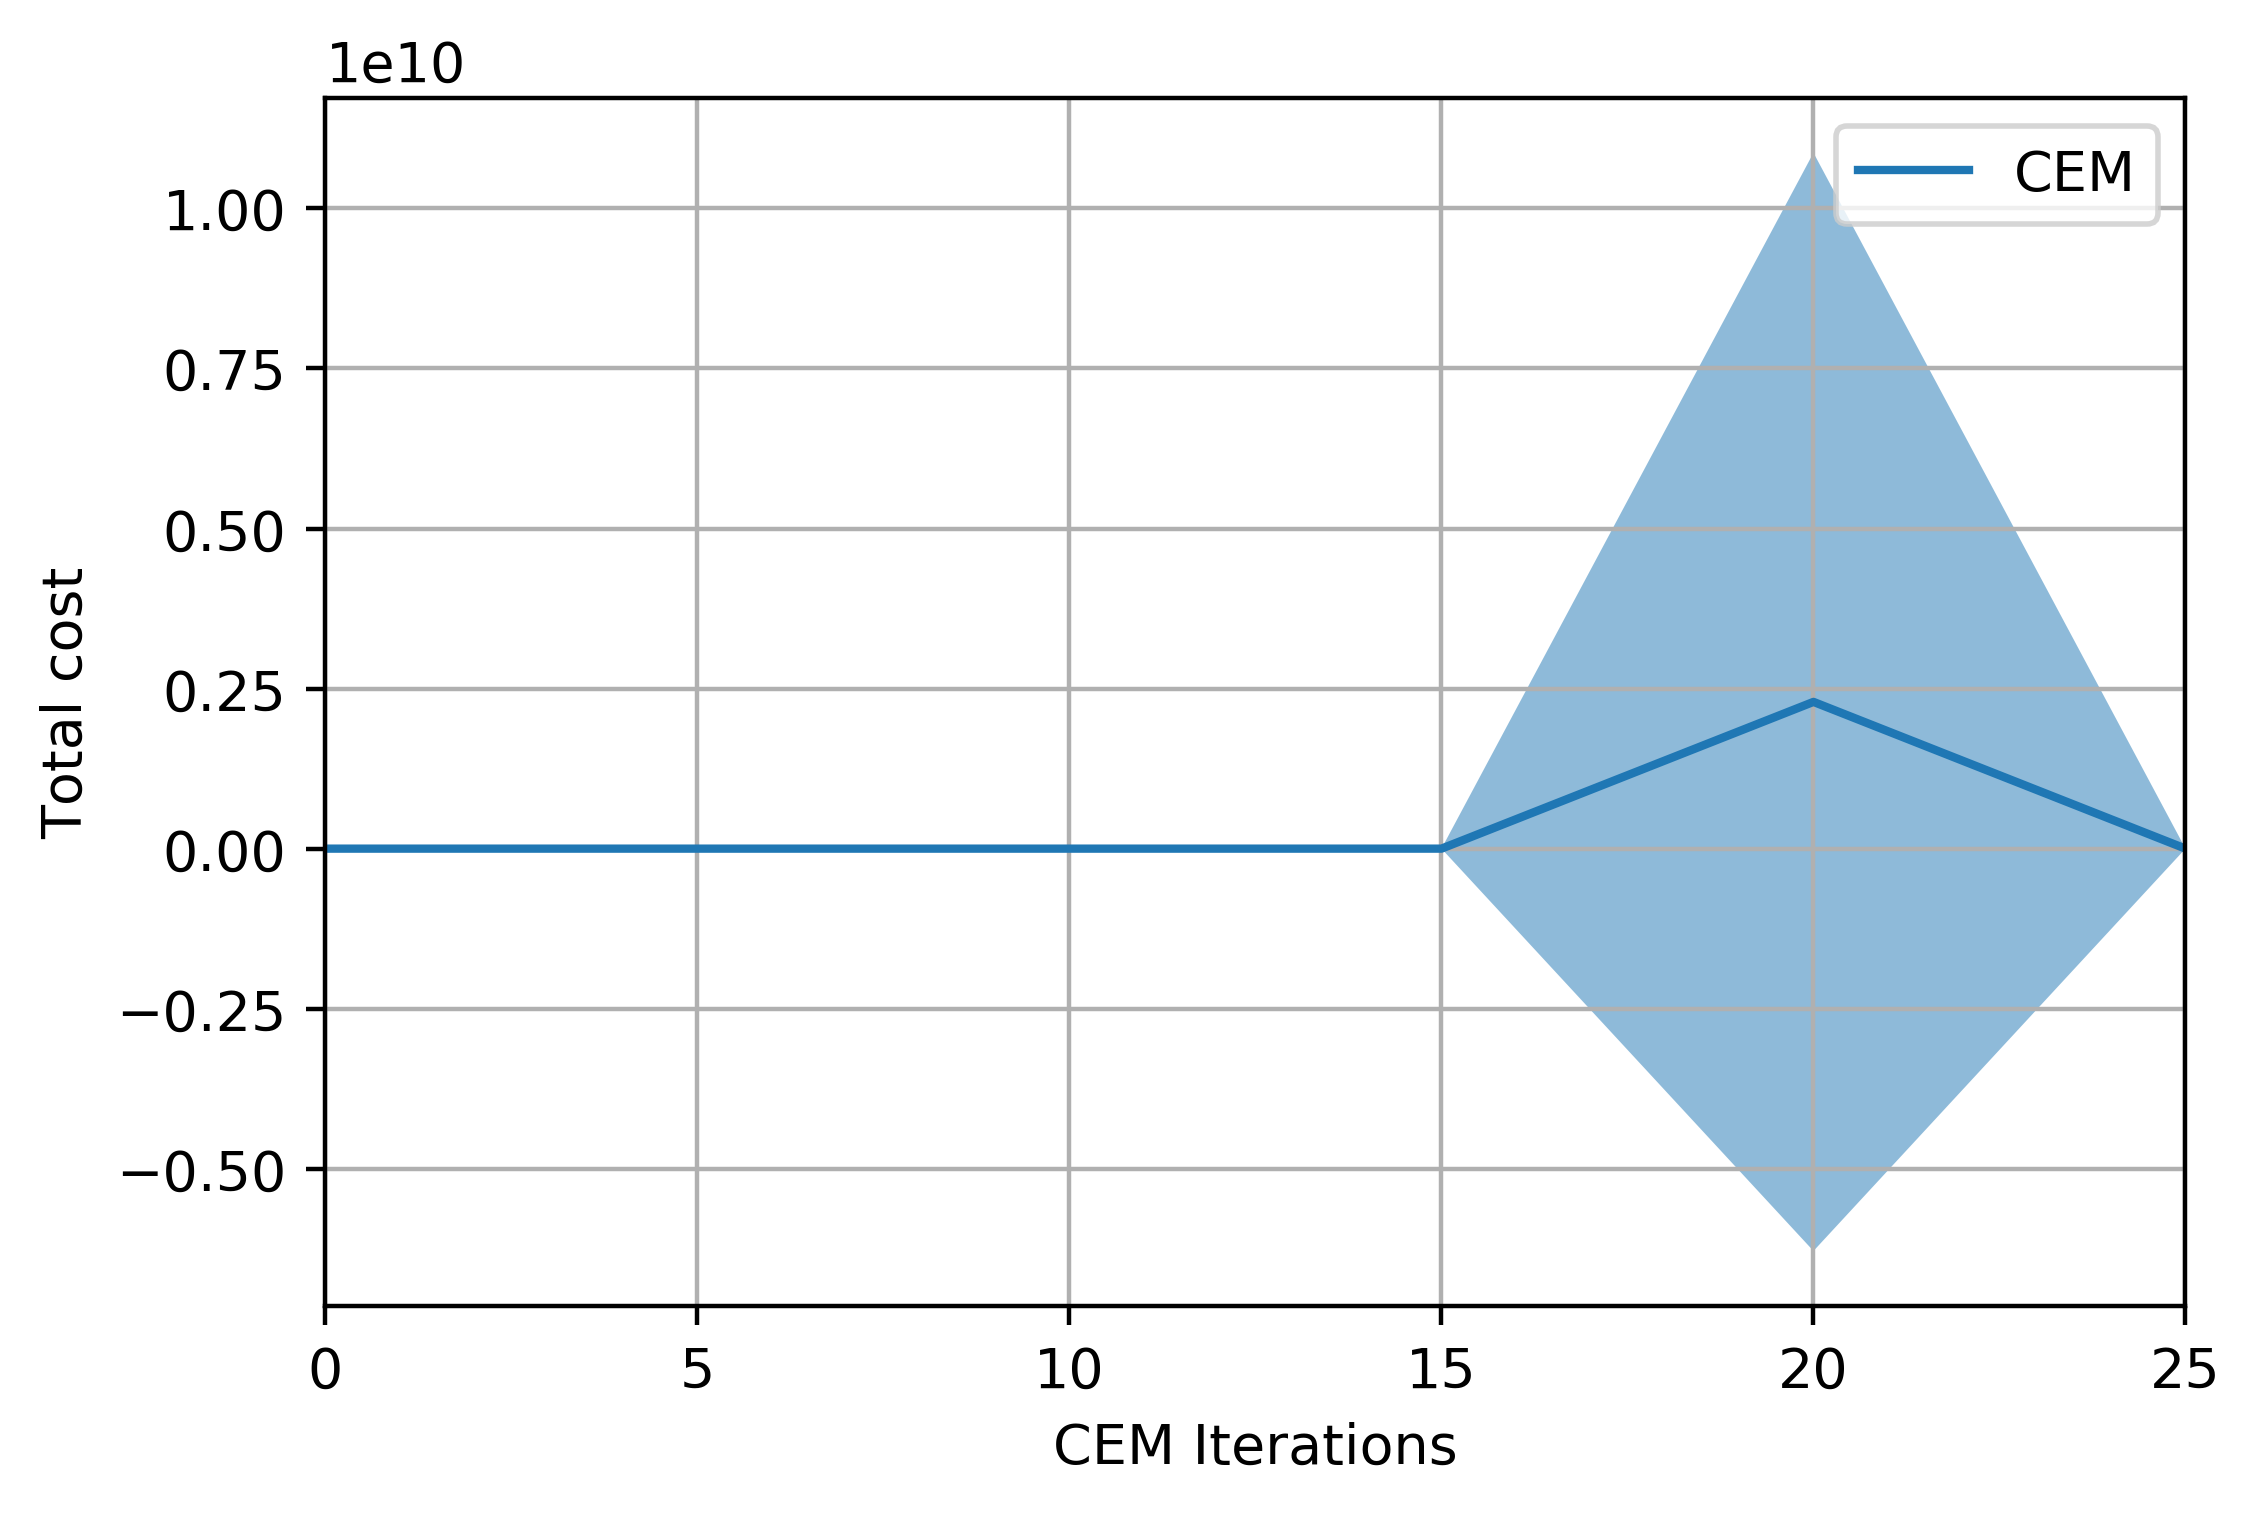

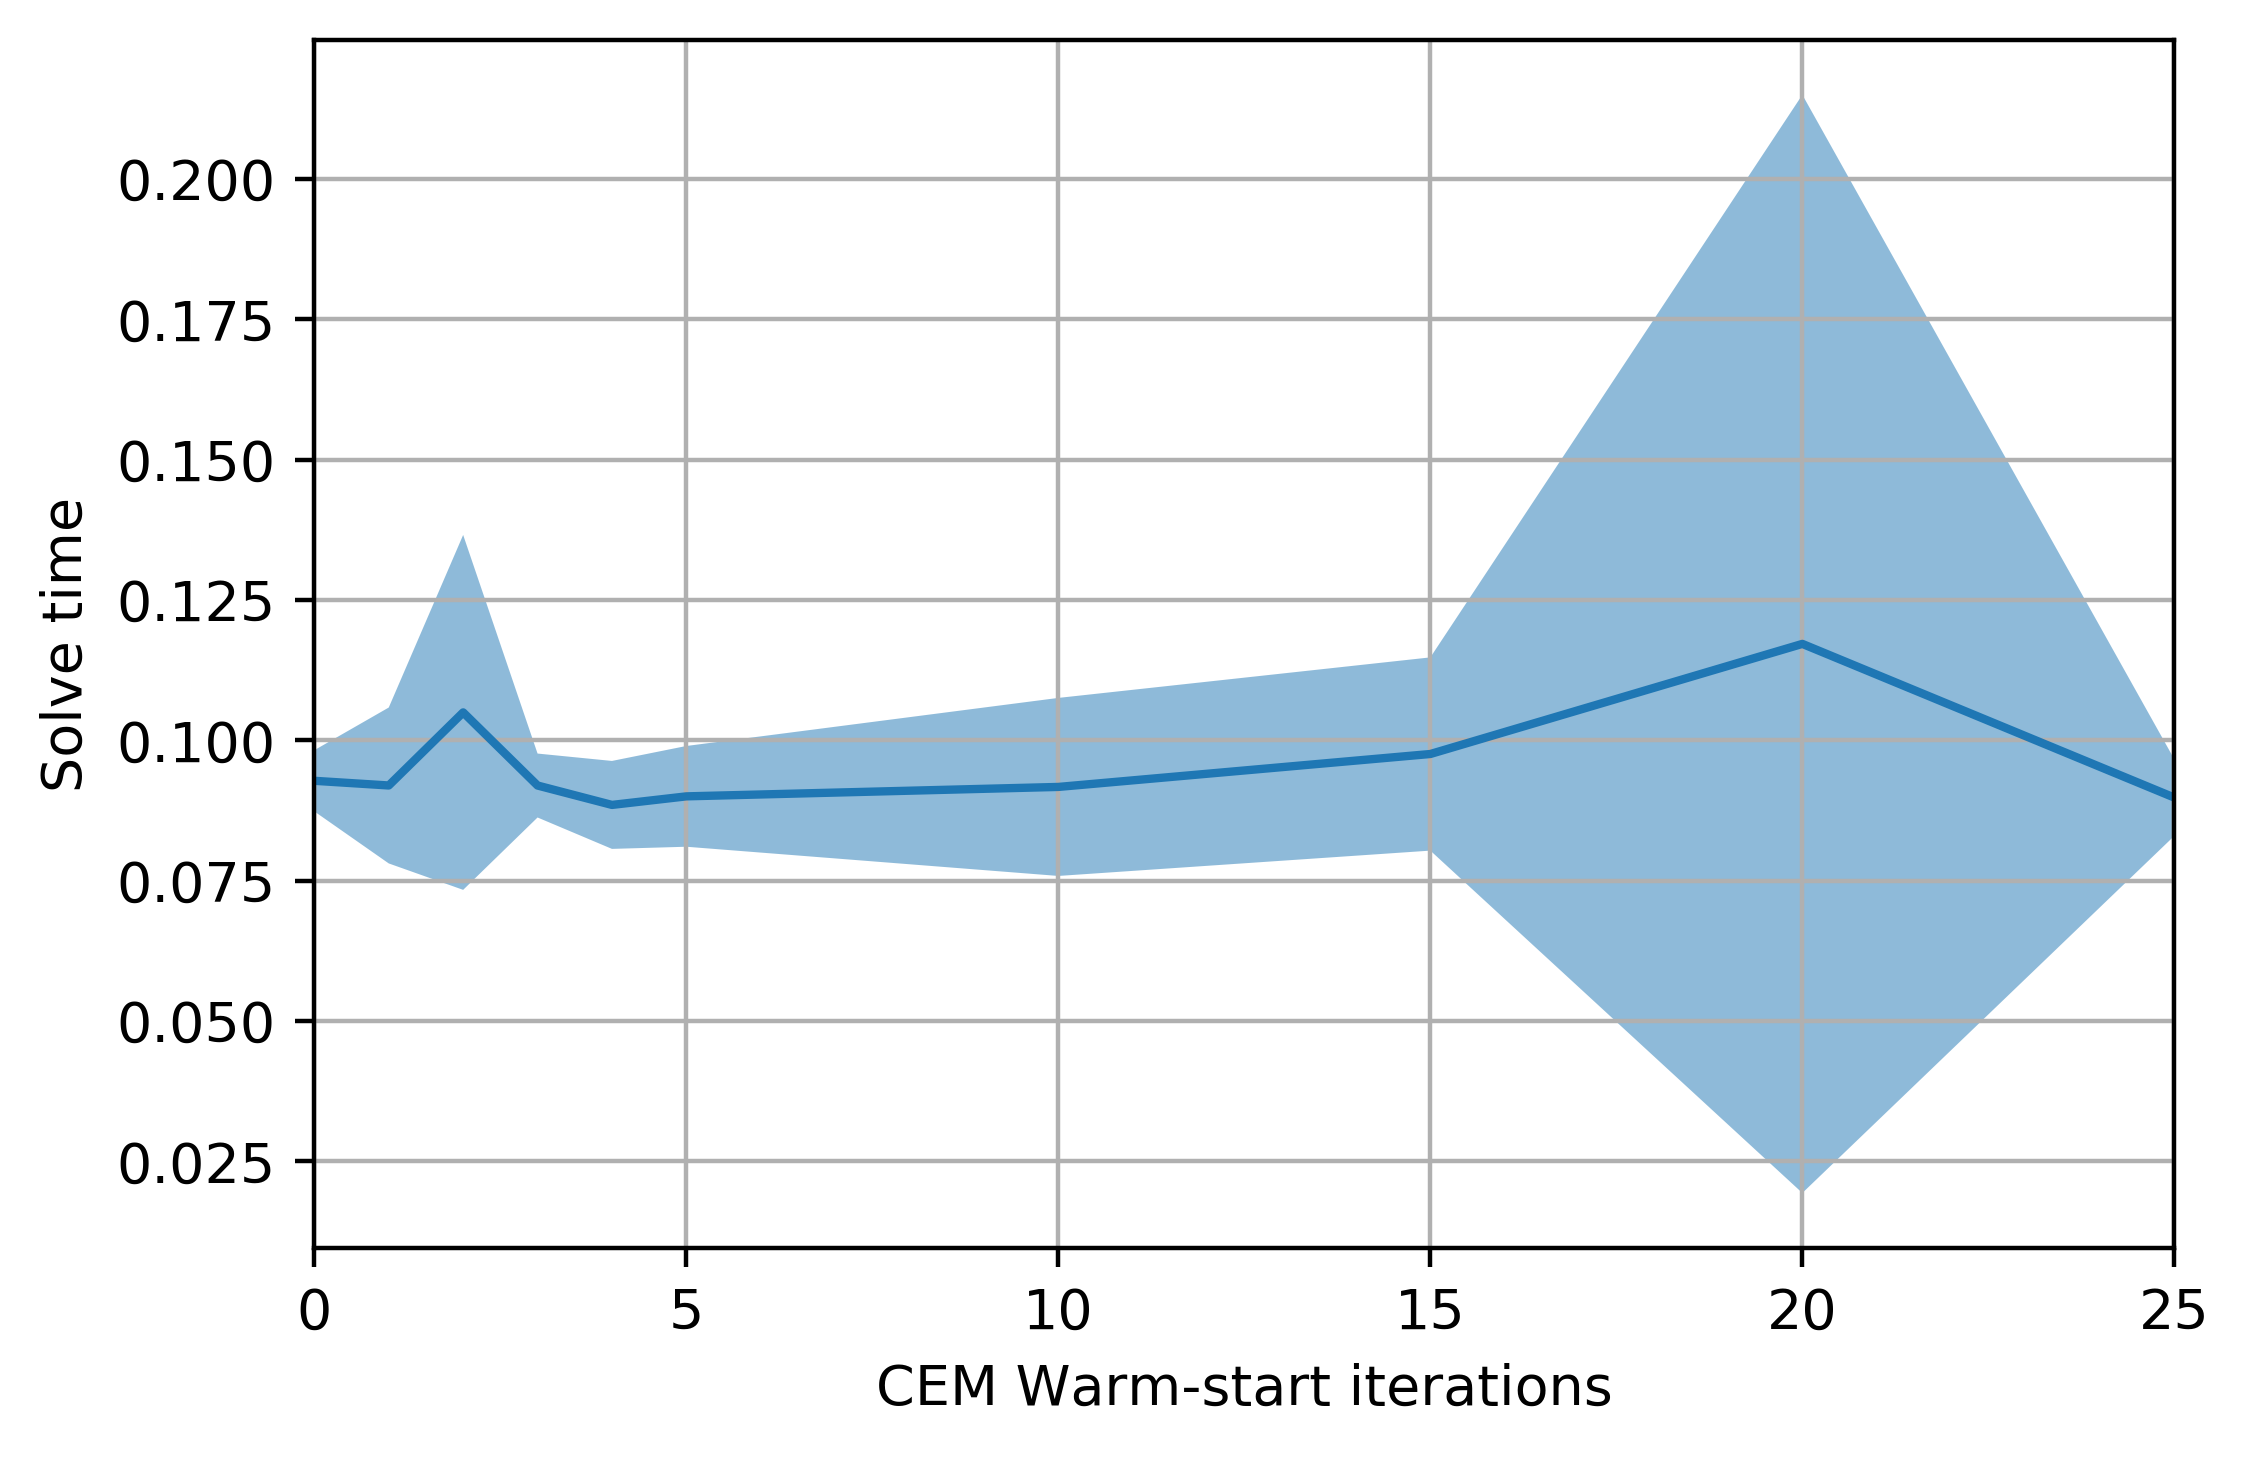

In [9]:
plt.plot(iters, iter_cost_mean, label='CEM')
mu = np.array(iter_cost_mean)
sig = np.array(iter_cost_std)
plt.fill_between(iters, mu-sig, mu+sig, alpha=0.5)

plt.legend()
plt.xlim(0,iters[-1])
plt.xlabel('CEM Iterations')
plt.ylabel('Total cost')


plt.figure()
plt.plot(iters, iter_times_mean)
mu = np.array(iter_times_mean)
sig = np.array(iter_times_std)
plt.fill_between(iters, mu-sig, mu+sig, alpha=0.5)
plt.xlim(0,iters[-1])
plt.xlabel('CEM Warm-start iterations')
plt.ylabel('Solve time')
plt.savefig('cem_warmstart_num_iter.pdf')

In [205]:
# Increasing stiffness

In [193]:
# Increasing planning horizon

In [ ]:
# Tuning map function
_, robots, contacts = spawn_models(robot_path = "config/franka.yaml",
                                   attr_path  = "config/attrs.yaml", 
                                   contact_path = "config/contact_test.yaml",
                                   sym_vars = [])
%timeit(robots['free'])
